# Flatiron Health mBC: Relaxed trials with GBM crude

***OBJECTIVE:*** **Reproduce 3 landmark clinical trials in metastatic breast cancer. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet inclusion criteria in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**

2. **In-silico trials:**
* PALOMA-2 
* PALOMA-3
* CLEOPATRA

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [4]:
# Calculates probability of survival at time t-months for risk groups. 
def psurv_t(low, med, high, t):
    low_t = low.survival_function_at_times(find_nearest(low.timeline, t)).values[0]*100
    med_t = med.survival_function_at_times(find_nearest(med.timeline, t)).values[0]*100
    high_t = high.survival_function_at_times(find_nearest(high.timeline, t)).values[0]*100
    pos_t = [low_t, med_t, high_t]
    return (pos_t)

In [5]:
# Calculates median overeall suvival for risk groups. 
def mos(low, med, high, comp):
    low_os = low.median_survival_time_
    med_os = med.median_survival_time_
    high_os = high.median_survival_time_
    comp_os = comp.median_survival_time_
    mos = [low_os, med_os, high_os, comp_os]
    return (mos)

In [6]:
# Calculates upper and lower 95% CI for median overall survival. 
def mos_ci(kmf):
    kmf_mos_low = (
        kmf.confidence_interval_[['KM_estimate_lower_0.95']]
        [kmf.confidence_interval_[['KM_estimate_lower_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_lower_0.95'], 0.5)]
        .idxmin()[0])

    kmf_mos_up = (
        kmf.confidence_interval_[['KM_estimate_upper_0.95']]
        [kmf.confidence_interval_[['KM_estimate_upper_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_upper_0.95'], 0.5)]
        .idxmin()[0])
    
    mos_ci = [kmf_mos_low, kmf_mos_up]
    return (mos_ci)

In [7]:
# Calculates upper and lower 95% CI for probability of survival at time t. 
def psurv_ci(kmf, t):
    kmf_psurv_ci_low = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][0]*100)

    kmf_psurv_ci_up = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][1]*100)
    
    psurv_ci = [kmf_psurv_ci_low, kmf_psurv_ci_up]
    return (psurv_ci)

In [8]:
# Calculate median overall survival or psurv error. 
def y_error(low_ci, med_ci, high_ci, surv_metric):
    error = [np.array([surv_metric[0] - low_ci[0],
                       surv_metric[1]- med_ci[0],
                       surv_metric[2] - high_ci[0]]),
               np.array([low_ci[1] - surv_metric[0],
                         med_ci[1] - surv_metric[1],
                         high_ci[1] - surv_metric[2]])]
    return(error)

In [9]:
# Cutoff decimlas to length n. 
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

### 1.2 Process data 

In [10]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(25341, 25341)

In [11]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6336, 6336)

In [12]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(31677, 31677)

In [13]:
crude_risk_score_df = pd.read_csv('crude_risk_score_df.csv')

In [14]:
df = pd.merge(df, crude_risk_score_df, on = 'PatientID')

In [15]:
df.to_csv('df_risk_crude.csv', index = False, header = True)

## Part 2: In silico trials 

### PALOMA-2: palbociclib plus letrozole vs. letrozole in hormone-sensitive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line palbociclib and letrozole or letrozole alone
* ER-positive within [-90, +30] days of first-line treatment
* HER-2 negative within [-90, +30] days of first-line treatment

#### Palbociclib plus letrozole 

In [16]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [17]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [18]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [19]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Palbociclib')].LineName.value_counts().head(10)

Letrozole,Palbociclib                  2503
Fulvestrant,Palbociclib                1324
Anastrozole,Palbociclib                 466
Palbociclib                             261
Exemestane,Palbociclib                  123
Letrozole,Leuprolide,Palbociclib         98
Goserelin,Letrozole,Palbociclib          90
Fulvestrant,Letrozole,Palbociclib        40
Anastrozole,Fulvestrant,Palbociclib      37
Palbociclib,Tamoxifen                    31
Name: LineName, dtype: int64

In [20]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Letrozole')].LineName.value_counts().head(10)

Letrozole                            2536
Letrozole,Palbociclib                2503
Letrozole,Ribociclib                  229
Abemaciclib,Letrozole                 190
Letrozole,Leuprolide,Palbociclib       98
Goserelin,Letrozole,Palbociclib        90
Fulvestrant,Letrozole                  64
Letrozole,Trastuzumab                  59
Fulvestrant,Letrozole,Palbociclib      40
Letrozole,Leuprolide                   40
Name: LineName, dtype: int64

In [21]:
let_palb = (
    line_therapy_fl
    .query('LineName == "Letrozole,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [22]:
row_ID(let_palb)

(2503, 2503)

In [23]:
let_palb.loc[:,'let_palb'] = 1

#### Letrozole

In [24]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Letrozole')].LineName.value_counts().head(10)

Letrozole                            2536
Letrozole,Palbociclib                2503
Letrozole,Ribociclib                  229
Abemaciclib,Letrozole                 190
Letrozole,Leuprolide,Palbociclib       98
Goserelin,Letrozole,Palbociclib        90
Fulvestrant,Letrozole                  64
Letrozole,Trastuzumab                  59
Fulvestrant,Letrozole,Palbociclib      40
Letrozole,Leuprolide                   40
Name: LineName, dtype: int64

In [25]:
let = (
    line_therapy_fl
    .query('LineName == "Letrozole"')
    [['PatientID', 'StartDate']]
)

In [26]:
row_ID(let)

(2536, 2536)

In [27]:
let.loc[:,'let_palb'] = 0

In [28]:
paloma2 = pd.concat([let_palb, let])

In [29]:
row_ID(paloma2)

(5039, 5039)

In [30]:
paloma2 = pd.merge(df_full, paloma2, on = 'PatientID', how = 'inner')

In [31]:
row_ID(paloma2)

(5039, 5039)

In [32]:
paloma2['StartDate'] = pd.to_datetime(paloma2['StartDate'])

#### ER-positive and HER-2 negative 

In [33]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [34]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma2['PatientID'])]

In [35]:
row_ID(biomarkers)

(36944, 5009)

In [36]:
biomarkers = pd.merge(biomarkers, paloma2[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [37]:
row_ID(biomarkers)

(36944, 5009)

In [38]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [39]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [40]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [41]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [42]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [43]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30 and date_diff >= -90')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [44]:
row_ID(er_status)

(3356, 3356)

In [45]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30 and date_diff >= -90')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [46]:
row_ID(her2_status)

(3186, 3186)

In [47]:
paloma2 = pd.merge(paloma2, er_status, on  = 'PatientID', how = 'left')

In [48]:
row_ID(paloma2)

(5039, 5039)

In [49]:
paloma2 = pd.merge(paloma2, her2_status, on  = 'PatientID', how = 'left')

In [50]:
row_ID(paloma2)

(5039, 5039)

In [51]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma2 = (
    paloma2
    .query('er == "Positive"')
    .query('her2== @her2_neg')
)

In [52]:
row_ID(paloma2)

(2816, 2816)

#### Time from treatment to progression/death or censor 

In [53]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [54]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [55]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [56]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [57]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [58]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [59]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [60]:
row_ID(mortality)

(31677, 31677)

In [61]:
paloma2 = pd.merge(paloma2, mortality, on = 'PatientID', how = 'inner')

In [62]:
row_ID(paloma2)

(2816, 2816)

In [63]:
progression = pd.read_csv ('Enhanced_MetBreastProgression.csv')

In [64]:
progression = progression[progression['PatientID'].isin(paloma2['PatientID'])][['PatientID', 'ProgressionDate']]

In [65]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [66]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [67]:
row_ID(progression)

(2815, 2815)

In [68]:
paloma2 = pd.merge(paloma2, progression, on = 'PatientID', how = 'left')

In [69]:
row_ID(paloma2)

(2816, 2816)

In [70]:
# Percent without progression date
len(paloma2.query('ProgressionDate.isna()', engine = 'python'))/len(paloma2)

0.4161931818181818

In [71]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [
    (paloma2['ProgressionDate'] - paloma2['StartDate']).dt.days,
    (paloma2['death_date'] - paloma2['StartDate']).dt.days,
    (paloma2['last_activity'] - paloma2['StartDate']).dt.days]

paloma2.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [72]:
paloma2 = paloma2.query('time_prog_treatment >= 0')

In [73]:
len(paloma2)

2751

In [74]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [1, 1, 0]

paloma2.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient count 

In [75]:
low_cutoff_paloma2 = paloma2.risk_score.quantile(1/3)

In [76]:
high_cutoff_paloma2 = paloma2.risk_score.quantile(2/3)

In [77]:
print('Palbociclib plus letrozole total:',  paloma2.query('let_palb == 1').shape[0])
print('High risk:', paloma2.query('let_palb == 1').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 1').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 1').query('risk_score <= @low_cutoff_paloma2').shape[0])

Palbociclib plus letrozole total: 1610
High risk: 471
Med risk: 526
Low risk: 613


In [78]:
print('Letrozole:',  paloma2.query('let_palb == 0').shape[0])
print('High risk:', paloma2.query('let_palb == 0').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 0').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 0').query('risk_score <= @low_cutoff_paloma2').shape[0])

Letrozole: 1141
High risk: 446
Med risk: 391
Low risk: 304


In [79]:
data = {'low': [low_cutoff_paloma2],
        'high': [high_cutoff_paloma2]}

risk_cutoff_breast = pd.DataFrame(data = data, index = ['paloma2'])

#### PFS curves without confounder adjustment 

In [80]:
paloma2 = paloma2.set_index('PatientID')

In [81]:
paloma2['pfs_status'] = paloma2['pfs_status'].astype('bool')

In [82]:
paloma2_low_plet = (
    paloma2
    .query('let_palb == 1')
    .query('risk_score <= @low_cutoff_paloma2')
    .index)

paloma2_low_let = (
    paloma2
    .query('let_palb == 0')
    .query('risk_score <= @low_cutoff_paloma2')
    .index)

paloma2_med_plet = (
    paloma2
    .query('let_palb == 1')
    .query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2')
    .index)

paloma2_med_let = (
    paloma2
    .query('let_palb == 0')
    .query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2')
    .index)

paloma2_high_plet = (
    paloma2
    .query('let_palb == 1')
    .query('risk_score >= @high_cutoff_paloma2')
    .index)

paloma2_high_let = (
    paloma2
    .query('let_palb == 0')
    .query('risk_score >= @high_cutoff_paloma2')
    .index)

paloma2_all_plet = (
    paloma2
    .query('let_palb == 1')
    .index)

paloma2_all_let = (
    paloma2
    .query('let_palb == 0')
    .index)

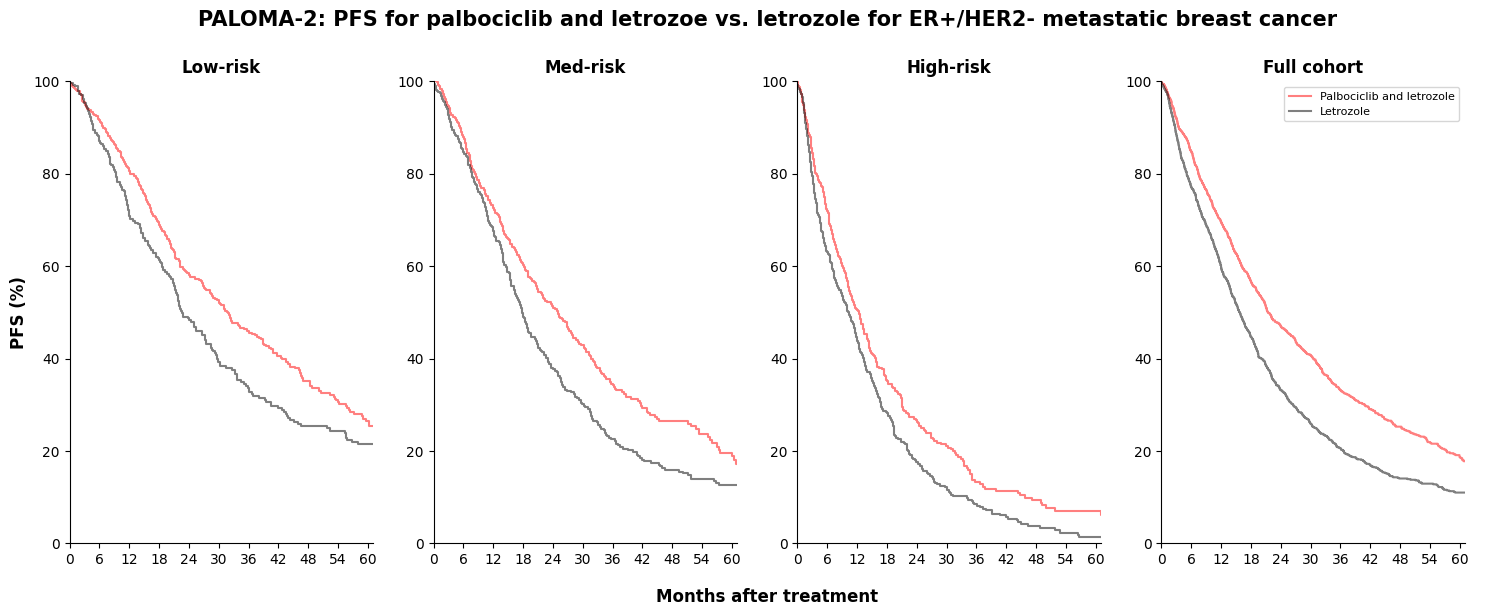

In [83]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_plet, pfs_prob_low_plet = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_low_plet]['pfs_status']),
                                                          np.array(paloma2.loc[paloma2_low_plet]['time_prog_treatment']))

time_low_let, pfs_prob_low_let = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_low_let]['pfs_status']),
                                                        np.array(paloma2.loc[paloma2_low_let]['time_prog_treatment']))

plt.step(time_low_plet/30, pfs_prob_low_plet*100, color = 'red', alpha = 0.5)
plt.step(time_low_let/30, pfs_prob_low_let*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('PFS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_plet, pfs_prob_med_plet = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_med_plet]['pfs_status']),
                                                          np.array(paloma2.loc[paloma2_med_plet]['time_prog_treatment']))

time_med_let, pfs_prob_med_let = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_med_let]['pfs_status']),
                                                        np.array(paloma2.loc[paloma2_med_let]['time_prog_treatment']))

plt.step(time_med_plet/30, pfs_prob_med_plet*100, color = 'red', alpha = 0.5)
plt.step(time_med_let/30, pfs_prob_med_let*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_plet, pfs_prob_high_plet = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_high_plet]['pfs_status']),
                                                            np.array(paloma2.loc[paloma2_high_plet]['time_prog_treatment']))

time_high_let, pfs_prob_high_let = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_high_let]['pfs_status']),
                                                          np.array(paloma2.loc[paloma2_high_let]['time_prog_treatment']))

plt.step(time_high_plet/30, pfs_prob_high_plet*100, color = 'red', alpha = 0.5)
plt.step(time_high_let/30, pfs_prob_high_let*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_plet, pfs_prob_all_plet = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_all_plet]['pfs_status']),
                                                          np.array(paloma2.loc[paloma2_all_plet]['time_prog_treatment']))

time_all_let, pfs_prob_all_let = kaplan_meier_estimator(np.array(paloma2.loc[paloma2_all_let]['pfs_status']),
                                                        np.array(paloma2.loc[paloma2_all_let]['time_prog_treatment']))

plt.step(time_all_plet/30, pfs_prob_all_plet*100, color = 'red', alpha = 0.5, label = 'Palbociclib and letrozole')
plt.step(time_all_let/30, pfs_prob_all_let*100, color = 'black', alpha = 0.5, label = 'Letrozole')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-2: PFS for palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### PFS with confounder adjustment via IPTW

In [84]:
paloma2_iptw = paloma2.filter(items = ['pfs_status',
                                       'time_prog_treatment',
                                       'let_palb',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_year',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'risk_score'])

In [85]:
paloma2_iptw.dtypes

pfs_status                bool
time_prog_treatment    float64
let_palb                 int64
age                      int64
gender                  object
race                    object
p_type                  object
delta_met_diagnosis      int64
met_year                 int64
commercial             float64
medicare               float64
medicaid               float64
ses                    float64
risk_score             float64
dtype: object

In [86]:
to_be_categorical = list(paloma2_iptw.select_dtypes(include = ['object']).columns)

In [87]:
to_be_categorical

['gender', 'race', 'p_type']

In [88]:
to_be_categorical.append('met_year')

In [89]:
to_be_categorical.append('ses')

In [90]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma2_iptw[x] = paloma2_iptw[x].astype('category')

In [91]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [92]:
# List of categorical features.
categorical_features = list(paloma2_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [93]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [94]:
paloma2_iptw_low = (
    paloma2_iptw
    .query('risk_score <= @low_cutoff_paloma2')
    .drop(columns = ['risk_score']))

paloma2_iptw_med = (
    paloma2_iptw
    .query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2')
    .drop(columns = ['risk_score']))

paloma2_iptw_high = (
    paloma2_iptw
    .query('risk_score >= @high_cutoff_paloma2')
    .drop(columns = ['risk_score']))

In [95]:
paloma2_low_x = preprocessor.fit_transform(paloma2_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_year',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses']))

paloma2_med_x = preprocessor.fit_transform(paloma2_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_year',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses']))

paloma2_high_x = preprocessor.fit_transform(paloma2_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses']))

In [96]:
lr_paloma2_low = LogisticRegression(max_iter = 1000)
lr_paloma2_low.fit(paloma2_low_x, paloma2_iptw_low['let_palb'])

LogisticRegression(max_iter=1000)

In [97]:
lr_paloma2_med = LogisticRegression(max_iter = 1000)
lr_paloma2_med.fit(paloma2_med_x, paloma2_iptw_med['let_palb'])

LogisticRegression(max_iter=1000)

In [98]:
lr_paloma2_high = LogisticRegression(max_iter = 1000)
lr_paloma2_high.fit(paloma2_high_x, paloma2_iptw_high['let_palb'])

LogisticRegression(max_iter=1000)

In [99]:
pred_low = lr_paloma2_low.predict_proba(paloma2_low_x)
pred_med = lr_paloma2_med.predict_proba(paloma2_med_x)
pred_high = lr_paloma2_high.predict_proba(paloma2_high_x)

In [100]:
paloma2_iptw_low['ps'] = pred_low[:, 1]
paloma2_iptw_med['ps'] = pred_med[:, 1]
paloma2_iptw_high['ps'] = pred_high[:, 1]

In [101]:
paloma2_iptw_low['weight'] = (
    np.where(paloma2_iptw_low['let_palb'] == 1, 1/paloma2_iptw_low['ps'], 1/(1 - paloma2_iptw_low['ps'])))

paloma2_iptw_med['weight'] = (
    np.where(paloma2_iptw_med['let_palb'] == 1, 1/paloma2_iptw_med['ps'], 1/(1 - paloma2_iptw_med['ps'])))

paloma2_iptw_high['weight'] = (
    np.where(paloma2_iptw_high['let_palb'] == 1, 1/paloma2_iptw_high['ps'], 1/(1 - paloma2_iptw_high['ps'])))

In [102]:
paloma2_iptw_all = pd.concat([paloma2_iptw_low, paloma2_iptw_med, paloma2_iptw_high])

In [103]:
# Low KM curves
kmf_low_plet_paloma2_iptw = KaplanMeierFitter()
kmf_low_let_paloma2_iptw = KaplanMeierFitter()

kmf_low_plet_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 1')['weight'])

kmf_low_let_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 0')['weight'])

# Med KM curves
kmf_med_plet_paloma2_iptw = KaplanMeierFitter()
kmf_med_let_paloma2_iptw = KaplanMeierFitter()

kmf_med_plet_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 1')['weight'])

kmf_med_let_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 0')['weight'])

# High KM curves 
kmf_high_plet_paloma2_iptw = KaplanMeierFitter()
kmf_high_let_paloma2_iptw = KaplanMeierFitter()

kmf_high_plet_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 1')['weight'])

kmf_high_let_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 0')['weight'])

# All KM curves 
kmf_all_plet_paloma2_iptw = KaplanMeierFitter()
kmf_all_let_paloma2_iptw = KaplanMeierFitter()

kmf_all_plet_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 1')['weight'])

kmf_all_let_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2655.72 total observations, 725.17 right-censored observations>

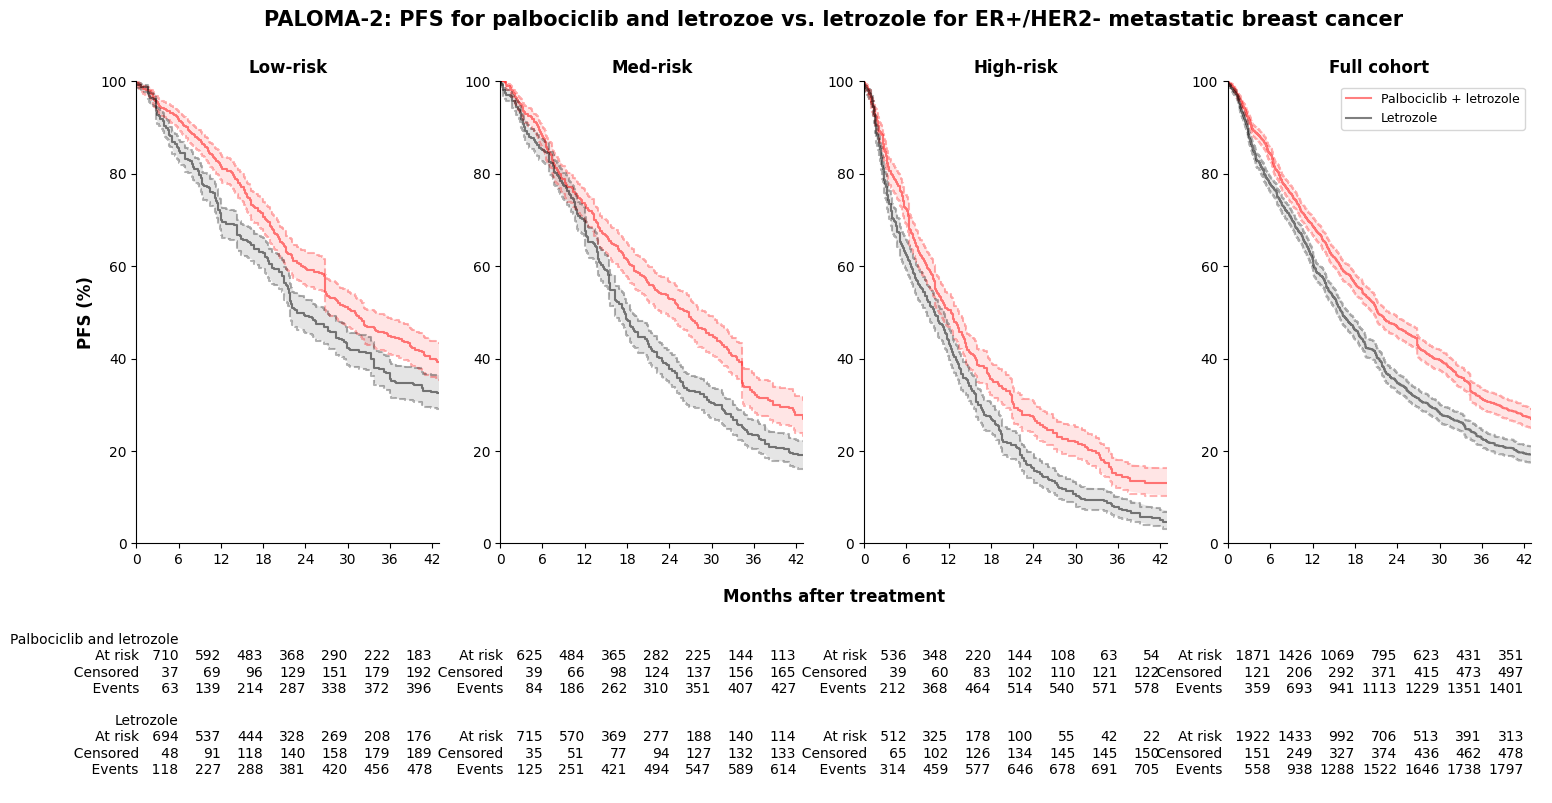

In [104]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_plet_paloma2_iptw.timeline, kmf_low_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_low_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_low_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_low_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_low_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_low_plet_paloma2_iptw.timeline, np.array(kmf_low_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_let_paloma2_iptw.timeline, kmf_low_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_low_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_low_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_low_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_low_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_low_let_paloma2_iptw.timeline, np.array(kmf_low_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('PFS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_plet_paloma2_iptw, kmf_low_let_paloma2_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Palbociclib and letrozole', 'Letrozole'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_plet_paloma2_iptw.timeline, kmf_med_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_med_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_med_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_med_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_med_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_med_plet_paloma2_iptw.timeline, np.array(kmf_med_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_let_paloma2_iptw.timeline, kmf_med_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_med_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_med_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_med_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_med_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_med_let_paloma2_iptw.timeline, np.array(kmf_med_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_plet_paloma2_iptw, kmf_med_let_paloma2_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_plet_paloma2_iptw.timeline, kmf_high_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_high_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_high_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_high_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_high_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_high_plet_paloma2_iptw.timeline, np.array(kmf_high_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_let_paloma2_iptw.timeline, kmf_high_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_high_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_high_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_high_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_high_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_high_let_paloma2_iptw.timeline, np.array(kmf_high_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_plet_paloma2_iptw, kmf_high_let_paloma2_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_plet_paloma2_iptw.timeline, kmf_all_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + letrozole')
plt.step(kmf_all_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_all_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_all_plet_paloma2_iptw.confidence_interval_.index, np.array(kmf_all_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_all_plet_paloma2_iptw.timeline, np.array(kmf_all_plet_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_plet_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_let_paloma2_iptw.timeline, kmf_all_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Letrozole')
plt.step(kmf_all_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_all_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_all_let_paloma2_iptw.confidence_interval_.index, np.array(kmf_all_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_all_let_paloma2_iptw.timeline, np.array(kmf_all_let_paloma2_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_let_paloma2_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

add_at_risk_counts(kmf_all_plet_paloma2_iptw, kmf_all_let_paloma2_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-2: PFS for palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [105]:
plet_paloma2_12_pfs = psurv_t(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              12)

let_paloma2_12_pfs = psurv_t(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             12)

plet_paloma2_24_pfs = psurv_t(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              24)

let_paloma2_24_pfs = psurv_t(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             24)

plet_paloma2_median_pfs = mos(kmf_low_plet_paloma2_iptw,
                              kmf_med_plet_paloma2_iptw,
                              kmf_high_plet_paloma2_iptw,
                              kmf_all_plet_paloma2_iptw)

let_paloma2_median_pfs = mos(kmf_low_let_paloma2_iptw,
                             kmf_med_let_paloma2_iptw,
                             kmf_high_let_paloma2_iptw,
                             kmf_all_let_paloma2_iptw)

In [106]:
print('All, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[3], 3))
print('All, letrozole: ',truncate(let_paloma2_median_pfs[3], 3))

print('Low, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[0], 3))
print('Low, letrozole: ',truncate(let_paloma2_median_pfs[0], 3))

print('Med, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[1], 3))
print('Med, letrozole: ',truncate(let_paloma2_median_pfs[1], 3))

print('High, palbo + letrozole: ',truncate(plet_paloma2_median_pfs[2], 3))
print('High, letrozole: ',truncate(let_paloma2_median_pfs[2], 3))

All, palbo + letrozole:  21.266
All, letrozole:  16.266
Low, palbo + letrozole:  31.066
Low, letrozole:  23.8
Med, palbo + letrozole:  27.033
Med, letrozole:  17.8
High, palbo + letrozole:  12.433
High, letrozole:  10.033


In [107]:
plet_paloma2_low_12_ci = psurv_ci(kmf_low_plet_paloma2_iptw, 12)
plet_paloma2_med_12_ci = psurv_ci(kmf_med_plet_paloma2_iptw, 12)
plet_paloma2_high_12_ci = psurv_ci(kmf_high_plet_paloma2_iptw, 12)

y_error_plet_paloma2_12 = y_error(plet_paloma2_low_12_ci,
                                  plet_paloma2_med_12_ci,
                                  plet_paloma2_high_12_ci,
                                  plet_paloma2_12_pfs)

In [108]:
let_paloma2_low_12_ci = psurv_ci(kmf_low_let_paloma2_iptw, 12)
let_paloma2_med_12_ci = psurv_ci(kmf_med_let_paloma2_iptw, 12)
let_paloma2_high_12_ci = psurv_ci(kmf_high_let_paloma2_iptw, 12)

y_error_let_paloma2_12 = y_error(let_paloma2_low_12_ci,
                                 let_paloma2_med_12_ci,
                                 let_paloma2_high_12_ci,
                                 let_paloma2_12_pfs)

In [109]:
plet_paloma2_low_24_ci = psurv_ci(kmf_low_plet_paloma2_iptw, 24)
plet_paloma2_med_24_ci = psurv_ci(kmf_med_plet_paloma2_iptw, 24)
plet_paloma2_high_24_ci = psurv_ci(kmf_high_plet_paloma2_iptw, 24)

y_error_plet_paloma2_24 = y_error(plet_paloma2_low_24_ci,
                                  plet_paloma2_med_24_ci,
                                  plet_paloma2_high_24_ci,
                                  plet_paloma2_24_pfs)

In [110]:
let_paloma2_low_24_ci = psurv_ci(kmf_low_let_paloma2_iptw, 24)
let_paloma2_med_24_ci = psurv_ci(kmf_med_let_paloma2_iptw, 24)
let_paloma2_high_24_ci = psurv_ci(kmf_high_let_paloma2_iptw, 24)

y_error_let_paloma2_24 = y_error(let_paloma2_low_24_ci,
                                 let_paloma2_med_24_ci,
                                 let_paloma2_high_24_ci,
                                 let_paloma2_24_pfs)

In [111]:
plet_paloma2_low_mpfs_ci = mos_ci(kmf_low_plet_paloma2_iptw)
plet_paloma2_med_mpfs_ci = mos_ci(kmf_med_plet_paloma2_iptw)
plet_paloma2_high_mpfs_ci = mos_ci(kmf_high_plet_paloma2_iptw)

y_error_plet_paloma2_mpfs = y_error(plet_paloma2_low_mpfs_ci,
                                    plet_paloma2_med_mpfs_ci,
                                    plet_paloma2_high_mpfs_ci,
                                    plet_paloma2_median_pfs)

In [112]:
let_paloma2_low_mpfs_ci = mos_ci(kmf_low_let_paloma2_iptw)
let_paloma2_med_mpfs_ci = mos_ci(kmf_med_let_paloma2_iptw)
let_paloma2_high_mpfs_ci = mos_ci(kmf_high_let_paloma2_iptw)

y_error_let_paloma2_mpfs = y_error(let_paloma2_low_mpfs_ci,
                                   let_paloma2_med_mpfs_ci,
                                   let_paloma2_high_mpfs_ci,
                                   let_paloma2_median_pfs)

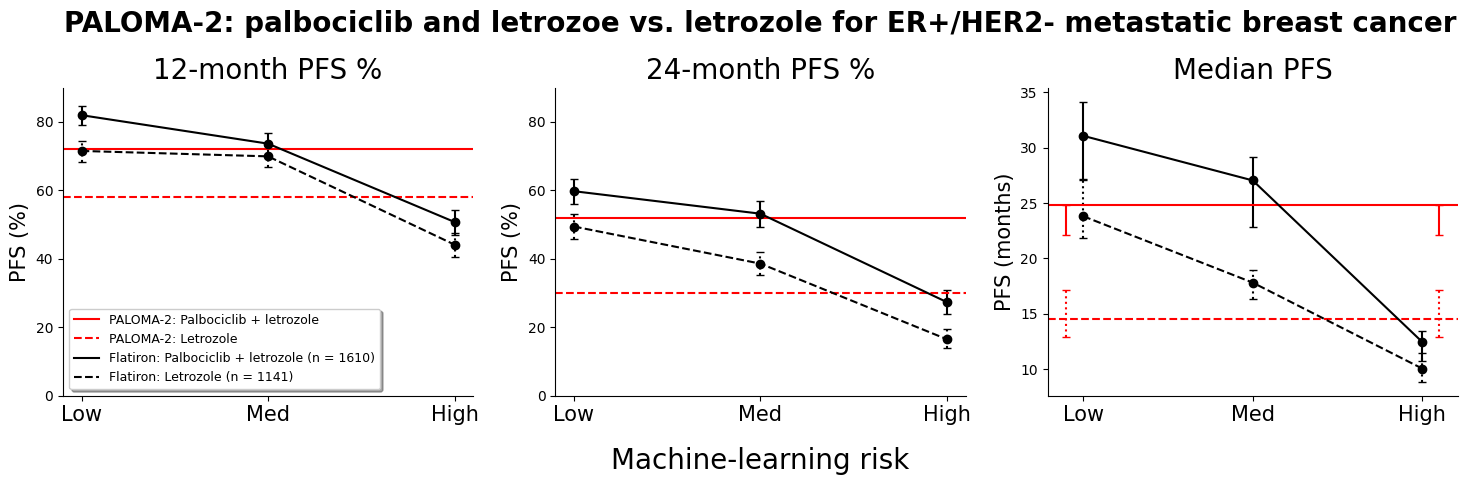

In [113]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, plet_paloma2_12_pfs, yerr = y_error_plet_paloma2_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 72, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, let_paloma2_12_pfs, yerr = y_error_let_paloma2_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 58, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('PFS (%)', size = 15)

plt.title('12-month PFS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, plet_paloma2_24_pfs, yerr = y_error_plet_paloma2_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 52, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, let_paloma2_24_pfs, yerr = y_error_let_paloma2_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 30, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('PFS (%)', size = 15)

plt.title('24-month PFS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, plet_paloma2_median_pfs[0:3], yerr = y_error_plet_paloma2_mpfs, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 24.8, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 24.8, yerr=[np.array([24.8-22.1]), np.array([24.8-24.8])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, let_paloma2_median_pfs[0:3], yerr = y_error_let_paloma2_mpfs, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 14.5, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 14.5, yerr=[np.array([14.5-12.9]), np.array([17.1-14.5])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('PFS (months)', size = 15)

plt.title('Median PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('PALOMA-2: palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'PALOMA-2: Palbociclib + letrozole'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'PALOMA-2: Letrozole'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Palbociclib + letrozole (n = {})'.format(paloma2.query('let_palb == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Letrozole (n = {})'.format(paloma2.query('let_palb == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('paloma2_summary_rc.png', bbox_inches = 'tight')

plt.show()

### PALOMA-3: palbociclib plus fulvestrant vs. fulvestrant in hormone-sensitive metastatic breast cancer that had previously progressed on endocrine therapy

**INCLUSION**
* Received first line estrogen therapy +/ one line of chemotherapy 
* Received second (or third) line palbociclib plus fulvestrant or fulvestrant alone 
* Did not receive CDK 4/6 inhibitor, fulvestrant, or everolimus in earlier lines
* ER/PR positive and HER-2 negative within (-inf, +30] days of start of treatment

#### 1. First line endorcine therapy + chemotherapy, second line fulvestrant +/- palbociclib

In [114]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [115]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [116]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [117]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin',
    'Buserelin']

chemo = [
    'Capecitabine',
    'Carboplatin',
    'Cyclophosphamide',
    'Docetaxel',
    'Eribulin',
    'Gemcitabine',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Vinorelbine']

exc =[
    'Abemaciclib',
    'Palbociclib',
    'Ribociclib',
    'Fulvestrant',
    'Everolimus']

In [118]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine,Letrozole                        31
Anastrozole,Capecitabine                      25
Anastrozole,Paclitaxel                        18
Letrozole,Paclitaxel Protein-Bound            17
Capecitabine,Tamoxifen                        14
Anastrozole,Paclitaxel Protein-Bound          14
Letrozole,Paclitaxel                          13
Capecitabine,Exemestane                       13
Paclitaxel,Tamoxifen                          11
Docetaxel,Letrozole,Pertuzumab,Trastuzumab    11
Name: LineName, dtype: int64

In [119]:
etchemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [120]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(etchemo_id)]
    .query('LineNumber == 2'))

In [121]:
etchemo_pf = (
    line_therapy_sec
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [122]:
row_ID(etchemo_pf)

(16, 16)

In [123]:
etchemo_f = (
    line_therapy_sec
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [124]:
row_ID(etchemo_pf)

(16, 16)

#### 2. First line endocrine therapy,  second line chemotherapy, third line palbociclib + fulvestrant

In [125]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Anastrozole                2943
Letrozole                  2536
Tamoxifen                  1305
Exemestane                  780
Leuprolide                   77
Anastrozole,Trastuzumab      66
Goserelin                    60
Letrozole,Trastuzumab        59
Leuprolide,Tamoxifen         56
Letrozole,Leuprolide         40
Name: LineName, dtype: int64

In [126]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [127]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
)

In [128]:
et_chemo_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [129]:
et_chemo_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [130]:
row_ID(et_chemo_pf)

(34, 34)

In [131]:
et_chemo_f = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [132]:
row_ID(et_chemo_f)

(58, 58)

#### 3. First line chemotherapy, second line endocrine therapy, third line palbociclib + fulvestrant

In [133]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(chemo)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine                             1324
Cyclophosphamide,Doxorubicin              690
Docetaxel,Pertuzumab,Trastuzumab          676
Paclitaxel                                589
Paclitaxel Protein-Bound                  584
Carboplatin,Gemcitabine                   407
Paclitaxel,Pertuzumab,Trastuzumab         289
Eribulin                                  261
Carboplatin,Paclitaxel                    250
Atezolizumab,Paclitaxel Protein-Bound     226
Name: LineName, dtype: int64

In [134]:
chemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [135]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(chemo_id)]
    .query('LineNumber == 2')
)

In [136]:
chemo_et_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(et))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [137]:
chemo_et_pf = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [138]:
row_ID(chemo_et_pf)

(39, 39)

In [139]:
chemo_et_f = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [140]:
row_ID(chemo_et_f)

(43, 43)

#### 4. First line endocrine therapy, second line palbociclib + fulvestrant

In [141]:
et_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [142]:
row_ID(et_pf)

(442, 442)

In [143]:
et_f = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [144]:
row_ID(et_f)

(787, 787)

In [145]:
paloma3_pf = pd.concat([etchemo_pf, et_chemo_pf, chemo_et_pf, et_pf])

In [146]:
paloma3_pf.loc[:, 'pfulv'] = 1

In [147]:
row_ID(paloma3_pf)

(531, 531)

In [148]:
paloma3_f = pd.concat([etchemo_f, et_chemo_f, chemo_et_f, et_f])

In [149]:
paloma3_f.loc[:, 'pfulv'] = 0

In [150]:
row_ID(paloma3_f)

(904, 904)

In [151]:
paloma3 = pd.concat([paloma3_pf, paloma3_f])

In [152]:
row_ID(paloma3)

(1435, 1435)

In [153]:
paloma3 = pd.merge(paloma3, df_full, on = 'PatientID', how = 'inner')

In [154]:
row_ID(paloma3)

(1435, 1435)

In [155]:
paloma3['StartDate'] = pd.to_datetime(paloma3['StartDate'])

#### ER- or PR-positive and HER-2 negative 

In [156]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [157]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma3['PatientID'])]

In [158]:
row_ID(biomarkers)

(10716, 1430)

In [159]:
biomarkers = pd.merge(biomarkers, paloma3[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [160]:
row_ID(biomarkers)

(10716, 1430)

In [161]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [162]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [163]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [164]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [165]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [166]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [167]:
row_ID(er_status)

(1296, 1296)

In [168]:
pr_status = (
    biomarkers
    .query('BiomarkerName == "PR"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'pr'})
   )

In [169]:
row_ID(pr_status)

(1255, 1255)

In [170]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [171]:
row_ID(her2_status)

(1248, 1248)

In [172]:
paloma3 = pd.merge(paloma3, er_status, on  = 'PatientID', how = 'left')

In [173]:
row_ID(paloma3)

(1435, 1435)

In [174]:
paloma3 = pd.merge(paloma3, pr_status, on  = 'PatientID', how = 'left')

In [175]:
row_ID(paloma3)

(1435, 1435)

In [176]:
paloma3 = pd.merge(paloma3, her2_status, on  = 'PatientID', how = 'left')

In [177]:
row_ID(paloma3)

(1435, 1435)

In [178]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma3 = (
    paloma3
    .query('er == "Positive" or pr == "Positive"')
    .query('her2== @her2_neg')
)

In [179]:
row_ID(paloma3)

(1164, 1164)

#### Time from treatment to progression/death or censor 

In [180]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [181]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [182]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [183]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [184]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [185]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [186]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [187]:
row_ID(mortality)

(31677, 31677)

In [188]:
paloma3 = pd.merge(paloma3, mortality, on = 'PatientID', how = 'left')

In [189]:
row_ID(paloma3)

(1164, 1164)

In [190]:
conditions = [
    (paloma3['death_status'] == 1),
    (paloma3['death_status'] == 0)]

choices = [
    (paloma3['death_date'] - paloma3['StartDate']).dt.days,
    (paloma3['last_activity'] - paloma3['StartDate']).dt.days]

paloma3.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [191]:
paloma3 = paloma3.query('timerisk_treatment >= 0')

#### Patient count 

In [192]:
low_cutoff_paloma3 = paloma3.risk_score.quantile(1/3)

In [193]:
high_cutoff_paloma3 = paloma3.risk_score.quantile(2/3)

In [194]:
print('Palobociclib plus fulvestrant total:',  paloma3.query('pfulv == 1').shape[0])
print('High risk:', paloma3.query('pfulv == 1').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 1').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 1').query('risk_score <= @low_cutoff_paloma3').shape[0])

Palobociclib plus fulvestrant total: 466
High risk: 148
Med risk: 150
Low risk: 168


In [195]:
print('Fulvestrant total:',  paloma3.query('pfulv == 0').shape[0])
print('High risk:', paloma3.query('pfulv == 0').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 0').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 0').query('risk_score <= @low_cutoff_paloma3').shape[0])

Fulvestrant total: 698
High risk: 240
Med risk: 238
Low risk: 220


In [196]:
risk_cutoff_breast.loc['paloma3'] = [low_cutoff_paloma3, high_cutoff_paloma3]

#### Survival curves without confounder adjustment 

In [197]:
paloma3 = paloma3.set_index('PatientID')

In [198]:
paloma3_low_pfulv = (
    paloma3
    .query('pfulv == 1')
    .query('risk_score <= @low_cutoff_paloma3')
    .index)

paloma3_low_fulv = (
    paloma3
    .query('pfulv == 0')
    .query('risk_score <= @low_cutoff_paloma3')
    .index)

paloma3_med_pfulv = (
    paloma3
    .query('pfulv == 1')
    .query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3')
    .index)

paloma3_med_fulv = (
    paloma3
    .query('pfulv == 0')
    .query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3')
    .index)

paloma3_high_pfulv = (
    paloma3
    .query('pfulv == 1')
    .query('risk_score >= @high_cutoff_paloma3')
    .index)

paloma3_high_fulv = (
    paloma3
    .query('pfulv == 0')
    .query('risk_score >= @high_cutoff_paloma3')
    .index)

paloma3_all_pfulv = (
    paloma3
    .query('pfulv == 1')
    .index)

paloma3_all_fulv = (
    paloma3
    .query('pfulv == 0')
    .index)

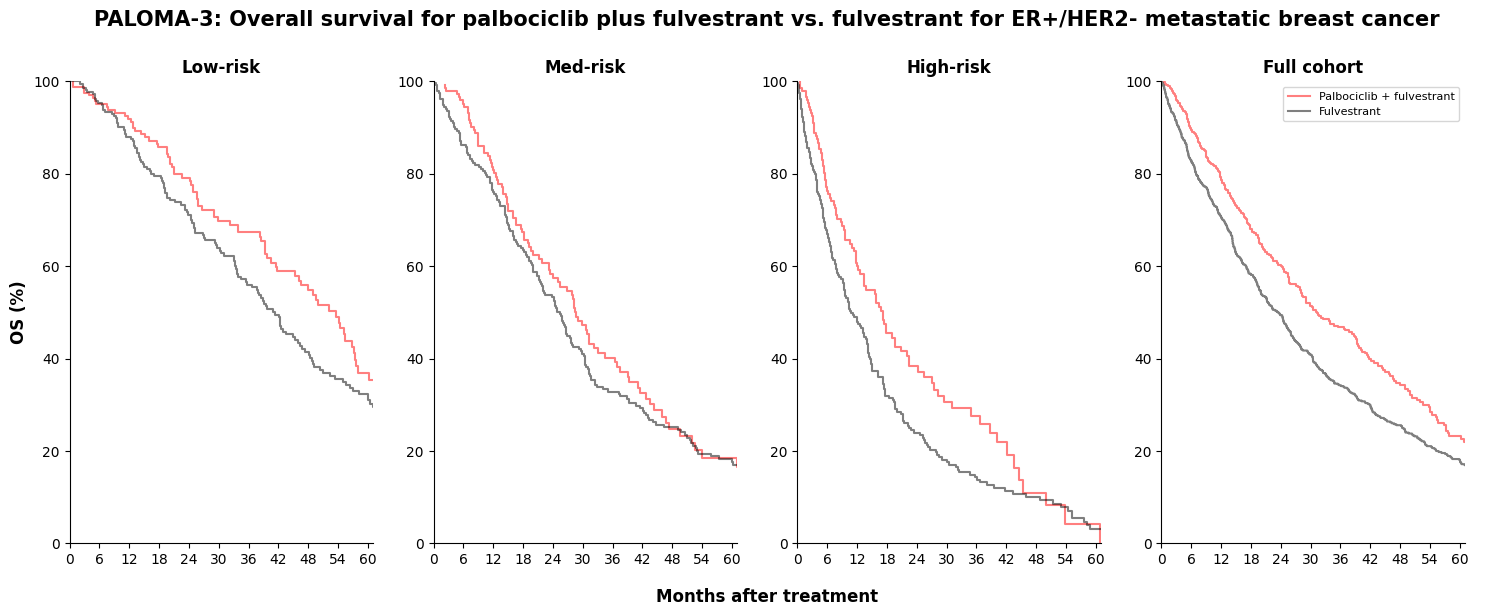

In [199]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_pfulv, survival_prob_low_pfulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_low_pfulv]['death_status']),
                                                                 np.array(paloma3.loc[paloma3_low_pfulv]['timerisk_treatment']))

time_low_fulv, survival_prob_low_fulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_low_fulv]['death_status']),
                                                               np.array(paloma3.loc[paloma3_low_fulv]['timerisk_treatment']))

plt.step(time_low_pfulv/30, survival_prob_low_pfulv*100, color = 'red', alpha = 0.5)
plt.step(time_low_fulv/30, survival_prob_low_fulv*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_pfulv, survival_prob_med_pfulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_med_pfulv]['death_status']),
                                                                 np.array(paloma3.loc[paloma3_med_pfulv]['timerisk_treatment']))

time_med_fulv, survival_prob_med_fulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_med_fulv]['death_status']),
                                                               np.array(paloma3.loc[paloma3_med_fulv]['timerisk_treatment']))

plt.step(time_med_pfulv/30, survival_prob_med_pfulv*100, color = 'red', alpha = 0.5)
plt.step(time_med_fulv/30, survival_prob_med_fulv*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_pfulv, survival_prob_high_pfulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_high_pfulv]['death_status']),
                                                                   np.array(paloma3.loc[paloma3_high_pfulv]['timerisk_treatment']))

time_high_fulv, survival_prob_high_fulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_high_fulv]['death_status']),
                                                                 np.array(paloma3.loc[paloma3_high_fulv]['timerisk_treatment']))

plt.step(time_high_pfulv/30, survival_prob_high_pfulv*100, color = 'red', alpha = 0.5)
plt.step(time_high_fulv/30, survival_prob_high_fulv*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all 
plt.subplot(1, 4, 4)

time_all_pfulv, survival_prob_all_pfulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_all_pfulv]['death_status']),
                                                                 np.array(paloma3.loc[paloma3_all_pfulv]['timerisk_treatment']))

time_all_fulv, survival_prob_all_fulv = kaplan_meier_estimator(np.array(paloma3.loc[paloma3_all_fulv]['death_status']),
                                                               np.array(paloma3.loc[paloma3_all_fulv]['timerisk_treatment']))

plt.step(time_all_pfulv/30, survival_prob_all_pfulv*100, color = 'red', alpha = 0.5, label = 'Palbociclib + fulvestrant')
plt.step(time_all_fulv/30, survival_prob_all_fulv*100, color = 'black', alpha = 0.5, label = 'Fulvestrant')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-3: Overall survival for palbociclib plus fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival with confounder adjustment via IPTW

In [200]:
paloma3_iptw = paloma3.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pfulv',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_year',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'risk_score'])

In [201]:
paloma3_iptw.dtypes

death_status              bool
timerisk_treatment     float64
pfulv                    int64
age                      int64
gender                  object
race                    object
p_type                  object
delta_met_diagnosis      int64
met_year                 int64
commercial             float64
medicare               float64
medicaid               float64
ses                    float64
risk_score             float64
dtype: object

In [202]:
to_be_categorical = list(paloma3_iptw.select_dtypes(include = ['object']).columns)

In [203]:
to_be_categorical

['gender', 'race', 'p_type']

In [204]:
to_be_categorical.append('met_year')

In [205]:
to_be_categorical.append('ses')

In [206]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma3_iptw[x] = paloma3_iptw[x].astype('category')

In [207]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [208]:
# List of categorical features.
categorical_features = list(paloma3_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [209]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [210]:
paloma3_iptw_low = (
    paloma3_iptw
    .query('risk_score <= @low_cutoff_paloma3')
    .drop(columns = ['risk_score']))

paloma3_iptw_med = (
    paloma3_iptw
    .query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3')
    .drop(columns = ['risk_score']))

paloma3_iptw_high = (
    paloma3_iptw
    .query('risk_score >= @high_cutoff_paloma3')
    .drop(columns = ['risk_score']))

In [211]:
paloma3_low_x = preprocessor.fit_transform(paloma3_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_year',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses']))

paloma3_med_x = preprocessor.fit_transform(paloma3_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_year',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses']))

paloma3_high_x = preprocessor.fit_transform(paloma3_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses']))

In [212]:
lr_paloma3_low = LogisticRegression(max_iter = 1000)
lr_paloma3_low.fit(paloma3_low_x, paloma3_iptw_low['pfulv'])

LogisticRegression(max_iter=1000)

In [213]:
lr_paloma3_med = LogisticRegression(max_iter = 1000)
lr_paloma3_med.fit(paloma3_med_x, paloma3_iptw_med['pfulv'])

LogisticRegression(max_iter=1000)

In [214]:
lr_paloma3_high = LogisticRegression(max_iter = 1000)
lr_paloma3_high.fit(paloma3_high_x, paloma3_iptw_high['pfulv'])

LogisticRegression(max_iter=1000)

In [215]:
pred_low = lr_paloma3_low.predict_proba(paloma3_low_x)
pred_med = lr_paloma3_med.predict_proba(paloma3_med_x)
pred_high = lr_paloma3_high.predict_proba(paloma3_high_x)

In [216]:
paloma3_iptw_low['ps'] = pred_low[:, 1]
paloma3_iptw_med['ps'] = pred_med[:, 1]
paloma3_iptw_high['ps'] = pred_high[:, 1]

In [217]:
paloma3_iptw_low['weight'] = (
    np.where(paloma3_iptw_low['pfulv'] == 1, 1/paloma3_iptw_low['ps'], 1/(1 - paloma3_iptw_low['ps'])))

paloma3_iptw_med['weight'] = (
    np.where(paloma3_iptw_med['pfulv'] == 1, 1/paloma3_iptw_med['ps'], 1/(1 - paloma3_iptw_med['ps'])))

paloma3_iptw_high['weight'] = (
    np.where(paloma3_iptw_high['pfulv'] == 1, 1/paloma3_iptw_high['ps'], 1/(1 - paloma3_iptw_high['ps'])))

In [218]:
paloma3_iptw_all = pd.concat([paloma3_iptw_low, paloma3_iptw_med, paloma3_iptw_high])

In [219]:
# Low KM curves
kmf_low_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_low_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_low_pfulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 1').death_status,
    weights = paloma3_iptw_low.query('pfulv == 1')['weight'])

kmf_low_fulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 0').death_status,
    weights = paloma3_iptw_low.query('pfulv == 0')['weight'])

# Med KM curves
kmf_med_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_med_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_med_pfulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 1').death_status,
    weights = paloma3_iptw_med.query('pfulv == 1')['weight'])

kmf_med_fulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 0').death_status,
    weights = paloma3_iptw_med.query('pfulv == 0')['weight'])

# High KM curves 
kmf_high_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_high_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_high_pfulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 1').death_status,
    weights = paloma3_iptw_high.query('pfulv == 1')['weight'])

kmf_high_fulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 0').death_status,
    weights = paloma3_iptw_high.query('pfulv == 0')['weight'])

# All KM curves 
kmf_all_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_all_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_all_pfulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 1').death_status,
    weights = paloma3_iptw_all.query('pfulv == 1')['weight'])

kmf_all_fulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 0').death_status,
    weights = paloma3_iptw_all.query('pfulv == 0')['weight'])


/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1113.52 total observations, 259.895 right-censored observations>

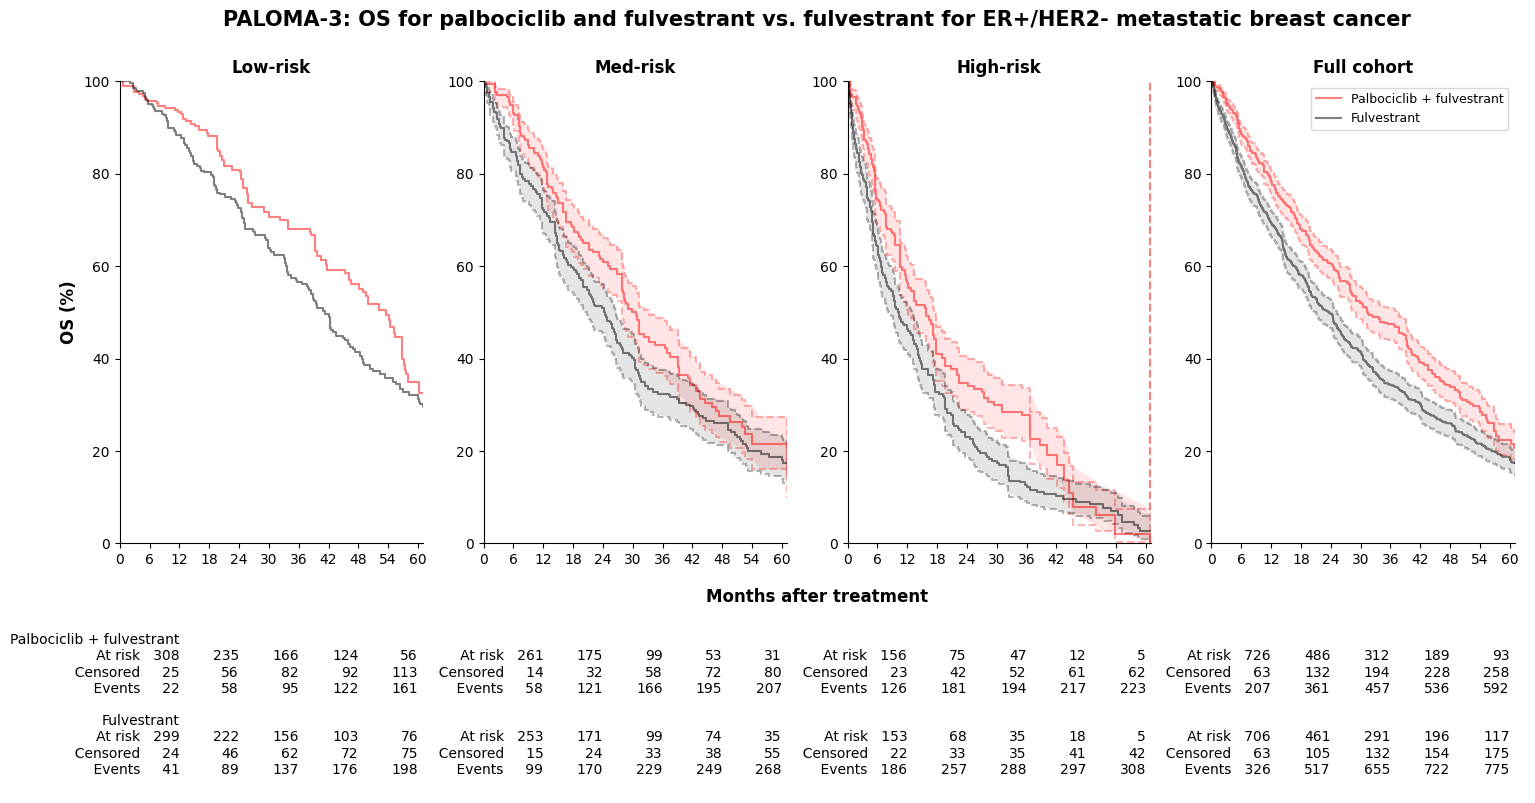

In [220]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pfulv_paloma3_iptw.timeline, kmf_low_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_pfulv_paloma3_iptw.timeline, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_fulv_paloma3_iptw.timeline, kmf_low_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_fulv_paloma3_iptw.timeline, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pfulv_paloma3_iptw, kmf_low_fulv_paloma3_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = ['Palbociclib + fulvestrant', 'Fulvestrant'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pfulv_paloma3_iptw.timeline, kmf_med_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_med_pfulv_paloma3_iptw.timeline, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_fulv_paloma3_iptw.timeline, kmf_med_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_med_fulv_paloma3_iptw.timeline, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pfulv_paloma3_iptw, kmf_med_fulv_paloma3_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pfulv_paloma3_iptw.timeline, kmf_high_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_high_pfulv_paloma3_iptw.timeline, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_fulv_paloma3_iptw.timeline, kmf_high_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_high_fulv_paloma3_iptw.timeline, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pfulv_paloma3_iptw, kmf_high_fulv_paloma3_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pfulv_paloma3_iptw.timeline, kmf_all_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + fulvestrant')
plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_all_pfulv_paloma3_iptw.timeline, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_fulv_paloma3_iptw.timeline, kmf_all_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Fulvestrant')
plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_all_fulv_paloma3_iptw.timeline, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pfulv_paloma3_iptw, kmf_all_fulv_paloma3_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-3: OS for palbociclib and fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [221]:
pfulv_paloma3_24_os = psurv_t(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              24)

fulv_paloma3_24_os = psurv_t(kmf_low_fulv_paloma3_iptw,
                             kmf_med_fulv_paloma3_iptw,
                             kmf_high_fulv_paloma3_iptw,
                             24)

pfulv_paloma3_36_os = psurv_t(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              36)

fulv_paloma3_36_os = psurv_t(kmf_low_fulv_paloma3_iptw,
                             kmf_med_fulv_paloma3_iptw,
                             kmf_high_fulv_paloma3_iptw,
                             36)

pfulv_paloma3_median_os = mos(kmf_low_pfulv_paloma3_iptw,
                              kmf_med_pfulv_paloma3_iptw,
                              kmf_high_pfulv_paloma3_iptw,
                              kmf_all_pfulv_paloma3_iptw)

fulv_paloma3_median_os = mos(kmf_low_fulv_paloma3_iptw,
                              kmf_med_fulv_paloma3_iptw,
                              kmf_high_fulv_paloma3_iptw,
                              kmf_all_fulv_paloma3_iptw)

In [222]:
print('All, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[3], 3))
print('All, fulvestrant: ',truncate(fulv_paloma3_median_os[3], 3))

print('Low, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[0], 3))
print('Low, fulvestrant: ',truncate(fulv_paloma3_median_os[0], 3))

print('Med, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[1], 3))
print('Med, fulvestrant: ',truncate(fulv_paloma3_median_os[1], 3))

print('High, palbo + fulvestrant: ',truncate(pfulv_paloma3_median_os[2], 3))
print('High, fulvestrant: ',truncate(fulv_paloma3_median_os[2], 3))

All, palbo + fulvestrant:  31.7
All, fulvestrant:  23.866
Low, palbo + fulvestrant:  54.1
Low, fulvestrant:  42.033
Med, palbo + fulvestrant:  30.633
Med, fulvestrant:  24.433
High, palbo + fulvestrant:  16.066
High, fulvestrant:  10.433


In [223]:
pfulv_paloma3_low_24_ci = psurv_ci(kmf_low_pfulv_paloma3_iptw, 24)
pfulv_paloma3_med_24_ci = psurv_ci(kmf_med_pfulv_paloma3_iptw, 24)
pfulv_paloma3_high_24_ci = psurv_ci(kmf_high_pfulv_paloma3_iptw, 24)

y_error_pfulv_paloma3_24 = y_error(pfulv_paloma3_low_24_ci,
                                   pfulv_paloma3_med_24_ci,
                                   pfulv_paloma3_high_24_ci,
                                   pfulv_paloma3_24_os)

In [224]:
fulv_paloma3_low_24_ci = psurv_ci(kmf_low_fulv_paloma3_iptw, 24)
fulv_paloma3_med_24_ci = psurv_ci(kmf_med_fulv_paloma3_iptw, 24)
fulv_paloma3_high_24_ci = psurv_ci(kmf_high_fulv_paloma3_iptw, 24)

y_error_fulv_paloma3_24 = y_error(fulv_paloma3_low_24_ci,
                                  fulv_paloma3_med_24_ci,
                                  fulv_paloma3_high_24_ci,
                                  fulv_paloma3_24_os)

In [225]:
pfulv_paloma3_low_36_ci = psurv_ci(kmf_low_pfulv_paloma3_iptw, 36)
pfulv_paloma3_med_36_ci = psurv_ci(kmf_med_pfulv_paloma3_iptw, 36)
pfulv_paloma3_high_36_ci = psurv_ci(kmf_high_pfulv_paloma3_iptw, 36)

y_error_pfulv_paloma3_36 = y_error(pfulv_paloma3_low_36_ci,
                                   pfulv_paloma3_med_36_ci,
                                   pfulv_paloma3_high_36_ci,
                                   pfulv_paloma3_36_os)

In [226]:
fulv_paloma3_low_36_ci = psurv_ci(kmf_low_fulv_paloma3_iptw, 36)
fulv_paloma3_med_36_ci = psurv_ci(kmf_med_fulv_paloma3_iptw, 36)
fulv_paloma3_high_36_ci = psurv_ci(kmf_high_fulv_paloma3_iptw, 36)

y_error_fulv_paloma3_36 = y_error(fulv_paloma3_low_36_ci,
                                  fulv_paloma3_med_36_ci,
                                  fulv_paloma3_high_36_ci,
                                  fulv_paloma3_36_os)

In [227]:
pfulv_paloma3_low_mos_ci = mos_ci(kmf_low_pfulv_paloma3_iptw)
pfulv_paloma3_med_mos_ci = mos_ci(kmf_med_pfulv_paloma3_iptw)
pfulv_paloma3_high_mos_ci = mos_ci(kmf_high_pfulv_paloma3_iptw)

y_error_pfulv_paloma3_mos = y_error(pfulv_paloma3_low_mos_ci,
                                    pfulv_paloma3_med_mos_ci,
                                    pfulv_paloma3_high_mos_ci,
                                    pfulv_paloma3_median_os)

In [228]:
fulv_paloma3_low_mos_ci = mos_ci(kmf_low_fulv_paloma3_iptw)
fulv_paloma3_med_mos_ci = mos_ci(kmf_med_fulv_paloma3_iptw)
fulv_paloma3_high_mos_ci = mos_ci(kmf_high_fulv_paloma3_iptw)

y_error_fulv_paloma3_mos = y_error(fulv_paloma3_low_mos_ci,
                                   fulv_paloma3_med_mos_ci,
                                   fulv_paloma3_high_mos_ci,
                                   fulv_paloma3_median_os)

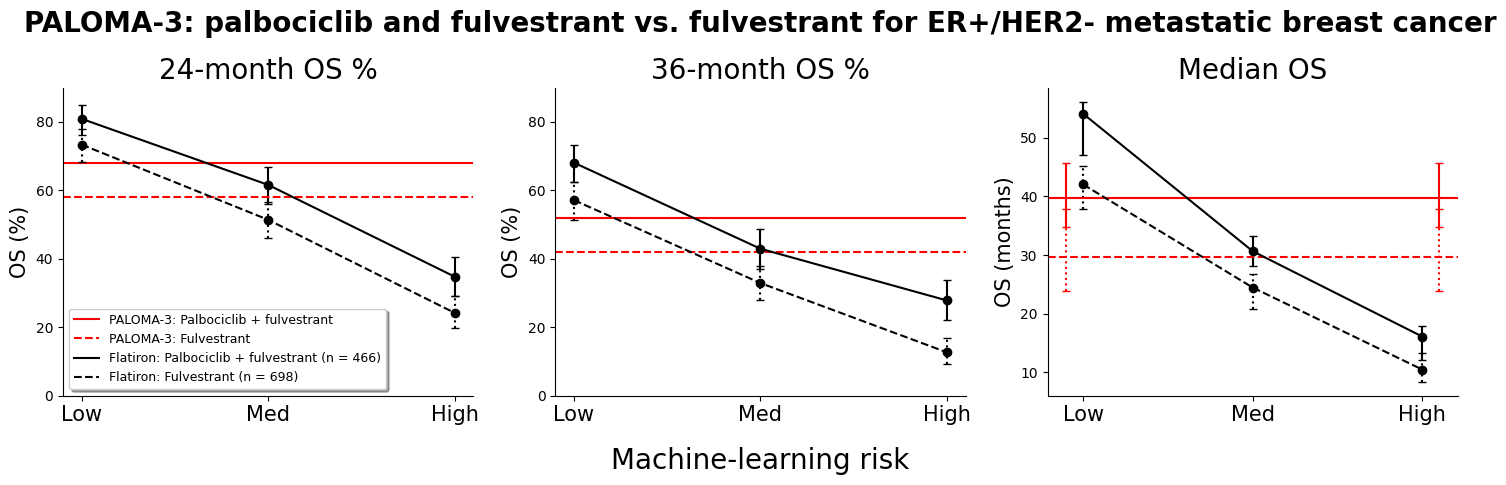

In [229]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pfulv_paloma3_24_os, yerr = y_error_pfulv_paloma3_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 68, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, fulv_paloma3_24_os, yerr = y_error_fulv_paloma3_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 58, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 36 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pfulv_paloma3_36_os, yerr = y_error_pfulv_paloma3_36, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 52, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, fulv_paloma3_36_os, yerr = y_error_fulv_paloma3_36, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 42, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('36-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pfulv_paloma3_median_os[0:3], yerr = y_error_pfulv_paloma3_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 39.7, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 39.7, yerr=[np.array([39.7-34.8]), np.array([45.7-39.7])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, fulv_paloma3_median_os[0:3], yerr = y_error_fulv_paloma3_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 29.7, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 29.7, yerr=[np.array([29.7-23.8]), np.array([37.9-29.7])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('PALOMA-3: palbociclib and fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'PALOMA-3: Palbociclib + fulvestrant'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'PALOMA-3: Fulvestrant'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Palbociclib + fulvestrant (n = {})'.format(paloma3.query('pfulv == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Fulvestrant (n = {})'.format(paloma3.query('pfulv == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('paloma3_summary_rc.png', bbox_inches = 'tight')

plt.show()

### CLEOPATRA: pertuzumab, trastuzumab, and docetaxel in HER2-positive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line pertuzumab, trastuzumab, and docetaxel/paclitaxel or first line trastuzumab + docetaxel/paclitaxel 
* First line of hormonal treatment is allowed
* HER-2 positive within (+30, -inf) of receipt of treatment 

#### First line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [230]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [231]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [232]:
tpdp = [
    'Docetaxel,Pertuzumab,Trastuzumab',
    'Docetaxel,Pertuzumab,Trastuzumab-Anns',
    'Docetaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel,Pertuzumab,Trastuzumab',
    'Paclitaxel,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Qyyp']

tpdp_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [233]:
tpdp_fl.loc[:, 'tpdp'] = 1

In [234]:
row_ID(tpdp_fl)

(1219, 1219)

In [235]:
tpd = [
    'Docetaxel,Trastuzumab',
    'Docetaxel,Trastuzumab-Anns',
    'Docetaxel,Trastuzumab-Qyyp',
    'Paclitaxel,Trastuzumab',
    'Paclitaxel,Trastuzumab-Anns',
    'Paclitaxel,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Trastuzumab',
    'Paclitaxel Protein-Bound,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Trastuzumab-Qyyp'] 

tpd_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [236]:
tpd_fl.loc[:, 'tpdp'] = 0

In [237]:
row_ID(tpdp_fl)

(1219, 1219)

#### First line endocrine therapy, second line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [238]:
all_treatment = line_therapy.LineName.unique()

In [239]:
treatment_list = []
for trt in all_treatment:
    treatment_list.extend(trt.split(","))

In [240]:
unique = list(dict.fromkeys(treatment_list))

In [241]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin']

In [242]:
unique.remove('Anastrozole')
unique.remove('Letrozole')
unique.remove('Exemestane')
unique.remove('Tamoxifen')
unique.remove('Leuprolide')
unique.remove('Goserelin')
unique.remove('Triptorelin')

In [243]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [244]:
(
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .LineName.value_counts().head(10)
)

Anastrozole               2943
Letrozole                 2536
Tamoxifen                 1305
Exemestane                 780
Leuprolide                  77
Goserelin                   60
Leuprolide,Tamoxifen        56
Letrozole,Leuprolide        40
Goserelin,Tamoxifen         36
Anastrozole,Leuprolide      35
Name: LineName, dtype: int64

In [245]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .PatientID
)

In [246]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2'))

In [247]:
et_tpdp = (
    line_therapy_sec
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [248]:
et_tpdp.loc[:, 'tpdp'] = 1

In [249]:
row_ID(et_tpdp)

(79, 79)

In [250]:
et_tpd = (
    line_therapy_sec
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [251]:
et_tpd.loc[:, 'tpdp'] = 0

In [252]:
row_ID(et_tpd)

(5, 5)

In [253]:
cleopatra_p = pd.concat([tpdp_fl, et_tpdp])

In [254]:
row_ID(cleopatra_p)

(1298, 1298)

In [255]:
cleopatra_np = pd.concat([tpd_fl, et_tpd])

In [256]:
row_ID(cleopatra_np)

(184, 184)

In [257]:
cleopatra = pd.concat([cleopatra_p, cleopatra_np])

In [258]:
row_ID(cleopatra)

(1482, 1482)

In [259]:
cleopatra = pd.merge(cleopatra, df_full, on = 'PatientID', how = 'inner')

In [260]:
row_ID(cleopatra)

(1482, 1482)

In [261]:
cleopatra['StartDate'] = pd.to_datetime(cleopatra['StartDate'])

#### HER-2 positive

In [262]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [263]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(cleopatra['PatientID'])]

In [264]:
row_ID(biomarkers)

(10765, 1482)

In [265]:
biomarkers = pd.merge(biomarkers, cleopatra[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [266]:
row_ID(biomarkers)

(10765, 1482)

In [267]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [268]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [269]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [270]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [271]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [272]:
her2_rel = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == @her2_rel')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [273]:
row_ID(her2_status)

(1377, 1377)

In [274]:
cleopatra = pd.merge(cleopatra, her2_status, on  = 'PatientID', how = 'left')

In [275]:
row_ID(cleopatra)

(1482, 1482)

In [276]:
her2_pos = ['IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

cleopatra = (
    cleopatra
    .query('her2== @her2_pos')
)

In [277]:
row_ID(cleopatra)

(1296, 1296)

#### Time from treatment to progression/death or censor 

In [278]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [279]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [280]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [281]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [282]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [283]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [284]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [285]:
row_ID(mortality)

(31677, 31677)

In [286]:
cleopatra = pd.merge(cleopatra, mortality, on = 'PatientID', how = 'left')

In [287]:
row_ID(cleopatra)

(1296, 1296)

In [288]:
conditions = [
    (cleopatra['death_status'] == 1),
    (cleopatra['death_status'] == 0)]

choices = [
    (cleopatra['death_date'] - cleopatra['StartDate']).dt.days,
    (cleopatra['last_activity'] - cleopatra['StartDate']).dt.days]

cleopatra.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [289]:
cleopatra = cleopatra.query('timerisk_treatment >= 0')

#### Patient count 

In [290]:
low_cutoff_cleopatra = cleopatra.risk_score.quantile(1/3)

In [291]:
high_cutoff_cleopatra = cleopatra.risk_score.quantile(2/3)

In [292]:
print('Pertuzumab + trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 1').shape[0])
print('High risk:', cleopatra.query('tpdp == 1').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 1').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 1').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Pertuzumab + trastuzumab + docetaxel/paclitaxel total: 1151
High risk: 375
Med risk: 390
Low risk: 386


In [293]:
print('Trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 0').shape[0])
print('High risk:', cleopatra.query('tpdp == 0').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 0').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 0').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Trastuzumab + docetaxel/paclitaxel total: 143
High risk: 57
Med risk: 41
Low risk: 45


In [294]:
risk_cutoff_breast.loc['cleopatra'] = [low_cutoff_cleopatra, high_cutoff_cleopatra]

In [295]:
risk_cutoff_breast

,low,high
paloma2,-0.773001,-0.163229
paloma3,-0.674621,-0.024017
cleopatra,-0.828093,-0.084191


In [296]:
risk_cutoff_breast.to_csv('risk_cutoff_breast.csv', index = True)

#### Survival curves without confounder adjustment 

In [297]:
cleopatra = cleopatra.set_index('PatientID')

In [298]:
cleopatra_low_tpdp = (
    cleopatra
    .query('tpdp == 1')
    .query('risk_score <= @low_cutoff_cleopatra')
    .index)

cleopatra_low_tdp = (
    cleopatra
    .query('tpdp == 0')
    .query('risk_score <= @low_cutoff_cleopatra')
    .index)

cleopatra_med_tpdp = (
    cleopatra
    .query('tpdp == 1')
    .query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra')
    .index)

cleopatra_med_tdp = (
    cleopatra
    .query('tpdp == 0')
    .query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra')
    .index)

cleopatra_high_tpdp = (
    cleopatra
    .query('tpdp == 1')
    .query('risk_score >= @high_cutoff_cleopatra')
    .index)

cleopatra_high_tdp = (
    cleopatra
    .query('tpdp == 0')
    .query('risk_score >= @high_cutoff_cleopatra')
    .index)

cleopatra_all_tpdp = (
    cleopatra
    .query('tpdp == 1')
    .index)

cleopatra_all_tdp = (
    cleopatra
    .query('tpdp == 0')
    .index)

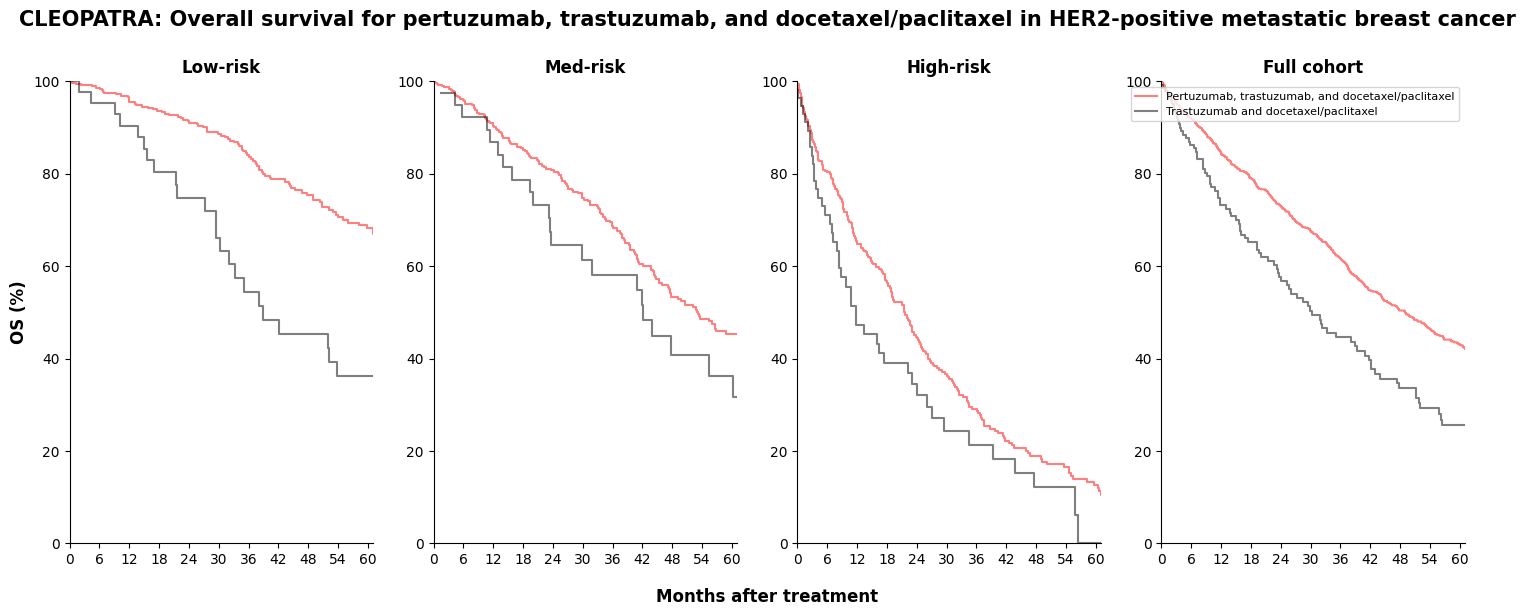

In [299]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_tpdp, survival_prob_low_tpdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_low_tpdp]['death_status']),
                                                               np.array(cleopatra.loc[cleopatra_low_tpdp]['timerisk_treatment']))

time_low_tdp, survival_prob_low_tdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_low_tdp]['death_status']),
                                                             np.array(cleopatra.loc[cleopatra_low_tdp]['timerisk_treatment']))

plt.step(time_low_tpdp/30, survival_prob_low_tpdp*100, color = 'red', alpha = 0.5)
plt.step(time_low_tdp/30, survival_prob_low_tdp*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_tpdp, survival_prob_med_tpdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_med_tpdp]['death_status']),
                                                               np.array(cleopatra.loc[cleopatra_med_tpdp]['timerisk_treatment']))

time_med_tdp, survival_prob_med_tdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_med_tdp]['death_status']),
                                                             np.array(cleopatra.loc[cleopatra_med_tdp]['timerisk_treatment']))

plt.step(time_med_tpdp/30, survival_prob_med_tpdp*100, color = 'red', alpha = 0.5)
plt.step(time_med_tdp/30, survival_prob_med_tdp*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_tpdp, survival_prob_high_tpdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_high_tpdp]['death_status']),
                                                                 np.array(cleopatra.loc[cleopatra_high_tpdp]['timerisk_treatment']))

time_high_tdp, survival_prob_high_tdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_high_tdp]['death_status']),
                                                               np.array(cleopatra.loc[cleopatra_high_tdp]['timerisk_treatment']))

plt.step(time_high_tpdp/30, survival_prob_high_tpdp*100, color = 'red', alpha = 0.5)
plt.step(time_high_tdp/30, survival_prob_high_tdp*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_tpdp, survival_prob_all_tpdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_all_tpdp]['death_status']),
                                                               np.array(cleopatra.loc[cleopatra_all_tpdp]['timerisk_treatment']))

time_all_tdp, survival_prob_all_tdp = kaplan_meier_estimator(np.array(cleopatra.loc[cleopatra_all_tdp]['death_status']),
                                                             np.array(cleopatra.loc[cleopatra_all_tdp]['timerisk_treatment']))

plt.step(time_all_tpdp/30, survival_prob_all_tpdp*100, color = 'red', alpha = 0.5, label = 'Pertuzumab, trastuzumab, and docetaxel/paclitaxel')
plt.step(time_all_tdp/30, survival_prob_all_tdp*100, color = 'black', alpha = 0.5, label = 'Trastuzumab and docetaxel/paclitaxel')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CLEOPATRA: Overall survival for pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot without IPTW

In [300]:
# Low KM curves
kmf_low_tpdp_cleopatra = KaplanMeierFitter()
kmf_low_tdp_cleopatra = KaplanMeierFitter()

kmf_low_tpdp_cleopatra.fit(
    cleopatra.loc[cleopatra_low_tpdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_low_tpdp]['death_status'])

kmf_low_tdp_cleopatra.fit(
    cleopatra.loc[cleopatra_low_tdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_low_tdp]['death_status'])

# Med KM curves
kmf_med_tpdp_cleopatra = KaplanMeierFitter()
kmf_med_tdp_cleopatra = KaplanMeierFitter()

kmf_med_tpdp_cleopatra.fit(
    cleopatra.loc[cleopatra_med_tpdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_med_tpdp]['death_status'])

kmf_med_tdp_cleopatra.fit(
    cleopatra.loc[cleopatra_med_tdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_med_tdp]['death_status'])

# High KM curves 
kmf_high_tpdp_cleopatra = KaplanMeierFitter()
kmf_high_tdp_cleopatra = KaplanMeierFitter()

kmf_high_tpdp_cleopatra.fit(
    cleopatra.loc[cleopatra_high_tpdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_high_tpdp]['death_status'])

kmf_high_tdp_cleopatra.fit(
    cleopatra.loc[cleopatra_high_tdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_high_tdp]['death_status'])

# All KM curves 
kmf_all_tpdp_cleopatra = KaplanMeierFitter()
kmf_all_tdp_cleopatra = KaplanMeierFitter()

kmf_all_tpdp_cleopatra.fit(
    cleopatra.loc[cleopatra_all_tpdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_all_tpdp]['death_status'])

kmf_all_tdp_cleopatra.fit(
    cleopatra.loc[cleopatra_all_tdp]['timerisk_treatment']/30,
    cleopatra.loc[cleopatra_all_tdp]['death_status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 143 total observations, 47 right-censored observations>

In [301]:
tpdp_cleopatra_24_os = psurv_t(kmf_low_tpdp_cleopatra,
                               kmf_med_tpdp_cleopatra,
                               kmf_high_tpdp_cleopatra,
                               24)

tdp_cleopatra_24_os = psurv_t(kmf_low_tdp_cleopatra,
                              kmf_med_tdp_cleopatra,
                              kmf_high_tdp_cleopatra,
                              24)

tpdp_cleopatra_36_os = psurv_t(kmf_low_tpdp_cleopatra,
                               kmf_med_tpdp_cleopatra,
                               kmf_high_tpdp_cleopatra,
                               36)

tdp_cleopatra_36_os = psurv_t(kmf_low_tdp_cleopatra,
                              kmf_med_tdp_cleopatra,
                              kmf_high_tdp_cleopatra,
                              36)

tpdp_cleopatra_median_os = mos(kmf_low_tpdp_cleopatra,
                               kmf_med_tpdp_cleopatra,
                               kmf_high_tpdp_cleopatra,
                               kmf_all_tpdp_cleopatra,)

tdp_cleopatra_median_os = mos(kmf_low_tdp_cleopatra,
                              kmf_med_tdp_cleopatra,
                              kmf_high_tdp_cleopatra,
                              kmf_all_tdp_cleopatra)

In [302]:
print('All, TPD/P: ',truncate(tpdp_cleopatra_median_os[3], 3))
print('All, TD/P: ',truncate(tdp_cleopatra_median_os[3], 3))

print('Low, TPD/P: ',truncate(tpdp_cleopatra_median_os[0], 3))
print('Low, TD/P: ',truncate(tdp_cleopatra_median_os[0], 3))

print('Med, TPD/P: ',truncate(tpdp_cleopatra_median_os[1], 3))
print('Med, TD/P: ',truncate(tdp_cleopatra_median_os[1], 3))

print('High, TPD/P: ',truncate(tpdp_cleopatra_median_os[2], 3))
print('High, TD/P: ',truncate(tdp_cleopatra_median_os[2], 3))

All, TPD/P:  49.2
All, TD/P:  31.833
Low, TPD/P:  90.933
Low, TD/P:  42.133
Med, TPD/P:  53.366
Med, TD/P:  43.066
High, TPD/P:  21.633
High, TD/P:  11.833


In [303]:
tpdp_cleopatra_low_24_ci = psurv_ci(kmf_low_tpdp_cleopatra, 24)
tpdp_cleopatra_med_24_ci = psurv_ci(kmf_med_tpdp_cleopatra, 24)
tpdp_cleopatra_high_24_ci = psurv_ci(kmf_high_tpdp_cleopatra, 24)

y_error_tpdp_cleopatra_24 = y_error(tpdp_cleopatra_low_24_ci,
                                    tpdp_cleopatra_med_24_ci,
                                    tpdp_cleopatra_high_24_ci,
                                    tpdp_cleopatra_24_os)

In [304]:
tdp_cleopatra_low_24_ci = psurv_ci(kmf_low_tdp_cleopatra, 24)
tdp_cleopatra_med_24_ci = psurv_ci(kmf_med_tdp_cleopatra, 24)
tdp_cleopatra_high_24_ci = psurv_ci(kmf_high_tdp_cleopatra, 24)

y_error_tdp_cleopatra_24 = y_error(tdp_cleopatra_low_24_ci,
                                   tdp_cleopatra_med_24_ci,
                                   tdp_cleopatra_high_24_ci,
                                   tdp_cleopatra_24_os)

In [305]:
tpdp_cleopatra_low_36_ci = psurv_ci(kmf_low_tpdp_cleopatra, 36)
tpdp_cleopatra_med_36_ci = psurv_ci(kmf_med_tpdp_cleopatra, 36)
tpdp_cleopatra_high_36_ci = psurv_ci(kmf_high_tpdp_cleopatra, 36)

y_error_tpdp_cleopatra_36 = y_error(tpdp_cleopatra_low_36_ci,
                                    tpdp_cleopatra_med_36_ci,
                                    tpdp_cleopatra_high_36_ci,
                                    tpdp_cleopatra_36_os)

In [306]:
tdp_cleopatra_low_36_ci = psurv_ci(kmf_low_tdp_cleopatra, 36)
tdp_cleopatra_med_36_ci = psurv_ci(kmf_med_tdp_cleopatra, 36)
tdp_cleopatra_high_36_ci = psurv_ci(kmf_high_tdp_cleopatra, 36)

y_error_tdp_cleopatra_36 = y_error(tdp_cleopatra_low_36_ci,
                                   tdp_cleopatra_med_36_ci,
                                   tdp_cleopatra_high_36_ci,
                                   tdp_cleopatra_36_os)

In [307]:
tpdp_cleopatra_low_mos_ci = mos_ci(kmf_low_tpdp_cleopatra)
tpdp_cleopatra_med_mos_ci = mos_ci(kmf_med_tpdp_cleopatra)
tpdp_cleopatra_high_mos_ci = mos_ci(kmf_high_tpdp_cleopatra)

y_error_tpdp_cleopatra_mos = y_error(tpdp_cleopatra_low_mos_ci,
                                     tpdp_cleopatra_med_mos_ci,
                                     tpdp_cleopatra_high_mos_ci,
                                     tpdp_cleopatra_median_os)

In [308]:
tdp_cleopatra_low_mos_ci = mos_ci(kmf_low_tdp_cleopatra)
tdp_cleopatra_med_mos_ci = mos_ci(kmf_med_tdp_cleopatra)
tdp_cleopatra_high_mos_ci = mos_ci(kmf_high_tdp_cleopatra)

y_error_tdp_cleopatra_mos = y_error(tdp_cleopatra_low_mos_ci,
                                    tdp_cleopatra_med_mos_ci,
                                    tdp_cleopatra_high_mos_ci,
                                    tdp_cleopatra_median_os)

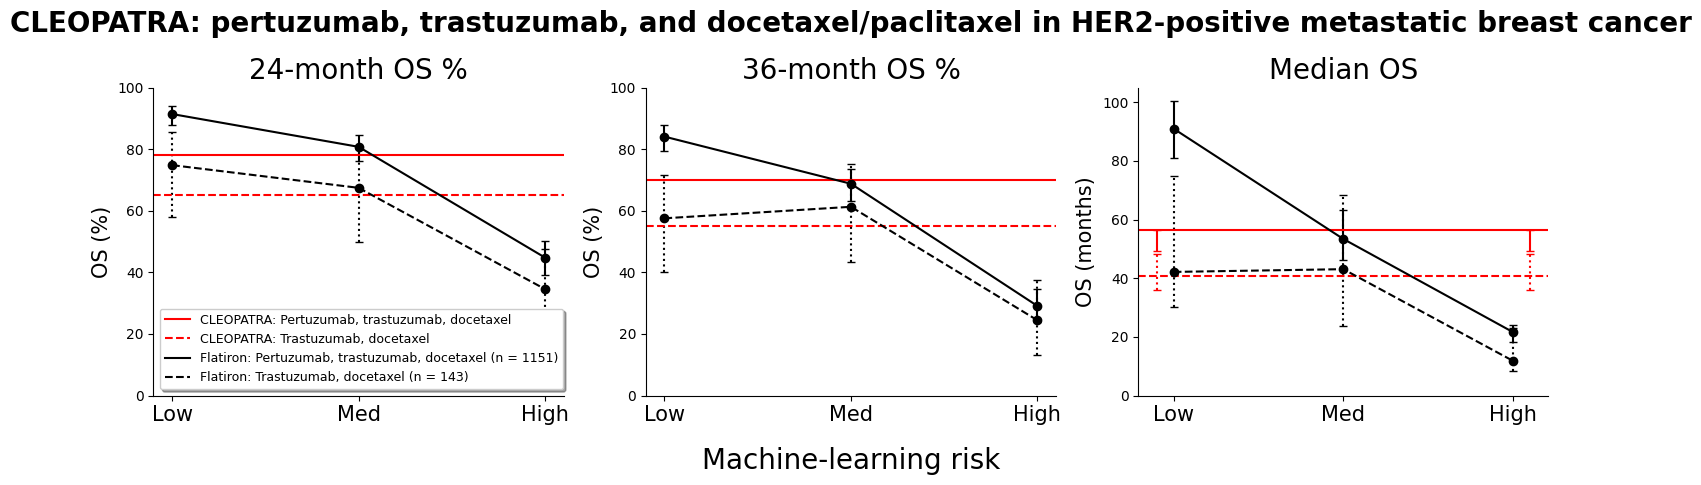

In [309]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, tpdp_cleopatra_24_os, yerr = y_error_tpdp_cleopatra_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 78, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, tdp_cleopatra_24_os, yerr = y_error_tdp_cleopatra_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 65, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 36 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, tpdp_cleopatra_36_os, yerr = y_error_tpdp_cleopatra_36, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 70, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, tdp_cleopatra_36_os, yerr = y_error_tdp_cleopatra_36, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 55, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('36-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, tpdp_cleopatra_median_os[0:3], yerr = y_error_tpdp_cleopatra_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 56.5, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 56.5, yerr=[np.array([56.5-49.3]), np.array([56.5-56.5])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, tdp_cleopatra_median_os[0:3], yerr = y_error_tdp_cleopatra_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 40.8, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 40.8, yerr=[np.array([40.8-35.8]), np.array([48.3-40.8])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylim(0, 105)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('CLEOPATRA: pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'CLEOPATRA: Pertuzumab, trastuzumab, docetaxel'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'CLEOPATRA: Trastuzumab, docetaxel'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pertuzumab, trastuzumab, docetaxel (n = {})'.format(cleopatra.query('tpdp == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Trastuzumab, docetaxel (n = {})'.format(cleopatra.query('tpdp == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('cleopatra_summary_rc.png', bbox_inches = 'tight')

plt.show()